# *Bacillus subtilis* Diauxic Shift

Here we will attempt to reproduce the results from [Rosenthal et al. 2018](https://elifesciences.org/articles/33099). 

The shared environment will contain 50 mM Malate and 22 mM Glucose. We will assume that the environment is 1L in volume - to avoid unit conversions. 
The simulation begins with a wild-type *Bacillus subtilis*. An `EnvironmentMonitor` process is added to monitor the Acetate concentration in the Shared Environment, once the concentration of Acetate exceeds the defined threshold - it will deploy a subpopulation of *Bacillus subtilis* that prefers metabolizing Acetate.

In [89]:
from copy import deepcopy
import cobra
import cobra.flux_analysis
from process_bigraph import Composite
from process_bigraph import ProcessTypes
from process_bigraph.emitter import gather_emitter_results

from cdFBA.utils import SHARED_ENVIRONMENT, SPECIES_STORE, THRESHOLDS, DFBA_RESULTS
from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction
from cdFBA.processes.dfbalauncher import get_env_monitor_spec, EnvironmentMonitor

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, model_from_file, set_concentration, set_kinetics
from cdFBA.utils import get_exchanges, get_substrates, get_reaction_map

from matplotlib import pyplot as plt
from pprint import pprint

import cProfile
import pstats
import io

In [90]:
model_file = 'iYO844'
model_dict = {
    'B.subtilis': model_file
}

In [91]:
exchanges = ['EX_ac_e', 'EX_mal__L_e', 'EX_glc__D_e']
volume = 1
spec = make_cdfba_composite(model_dict, medium_type=None, exchanges=exchanges, volume=volume, interval=0.1)

In [92]:
# Set environmental threshold
spec[THRESHOLDS] = {
        "Acetate": {
            "type": "add",
            "substrate": "Acetate",
            "range": {
                "upper": 3,
                "lower": None,
            },
            "parent": "B.subtilis",
            "name": "B.subtilis 2",
            "changes":{
                "gene_knockout": [],
                "reaction_knockout": [],
                "bounds": {},
                "kinetics": {
                    "Acetate": (0.5, 14),
                    "D-Glucose": (0.2, 5),
                    "L-Malate": (0.2, 5)
                },
            },
            "mass": 0.25,
        }
    }
spec["monitor"] = get_env_monitor_spec(interval=1.0)

In [93]:
spec["monitor"] = get_env_monitor_spec(interval=0.1)

In [94]:
#Set reaction bounds
spec[SPECIES_STORE]['B.subtilis']['config']['bounds'] = {
            'EX_o2_e': {'lower': -2, 'upper': None},
            'ATPM': {'lower': 1, 'upper': 1},
            'EX_ac_e': {'lower': 0, 'upper': None},
        }
#Set initial concentrations
concentrations = {
    'Acetate': 0,
    'D-Glucose': 22,
    'L-Malate': 55,
    # ' R  Acetoin C4H8O2': 0
}
set_concentration(spec, concentrations)

In [95]:
# set kinetics
kinetics = {
    "L-Malate": (0.02, 14),
    "D-Glucose": (0.02, 14),
    "Acetate": (0.5, 0)
}
for species in model_dict.keys():
    set_kinetics(species, spec, kinetics)

In [96]:
#set emitter specs
spec["emitter"] = {
    "_type": "step",
    "address": "local:ram-emitter",
    "config": {
        "emit": {
            "shared_environment": "any",
            "global_time": "any",
        }
    },
    "inputs": {
        "shared_environment": [SHARED_ENVIRONMENT],
        "global_time": ["global_time"]
    }
}

In [97]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)
core.register_process('EnvironmentMonitor', EnvironmentMonitor)

In [98]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [99]:
sim.run(40)

In [100]:
results = gather_emitter_results(sim)[('emitter',)]

In [101]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

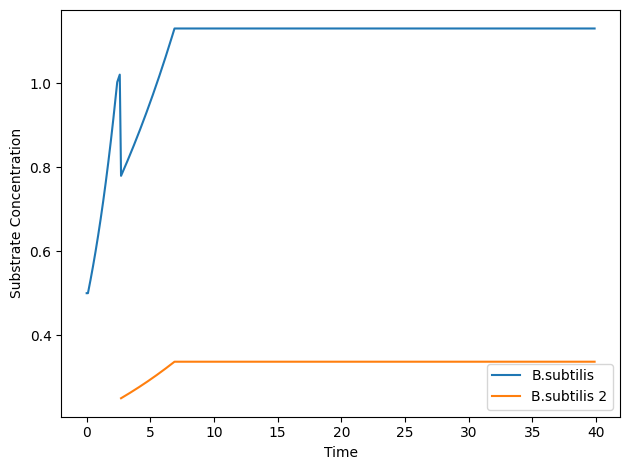

In [102]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in ['Acetate', 'L-Malate', 'D-Glucose']:
        length_diff = len(timepoints) - len(value)
        if length_diff > 0:
            # Align the data to the end of the timepoints
            aligned_timepoints = timepoints[length_diff:]
        else:
            aligned_timepoints = timepoints
        ax.plot(aligned_timepoints, value, label=key)
plt.xlabel("Time")
plt.ylabel("Substrate Concentration")
plt.legend()
plt.tight_layout()
plt.show()

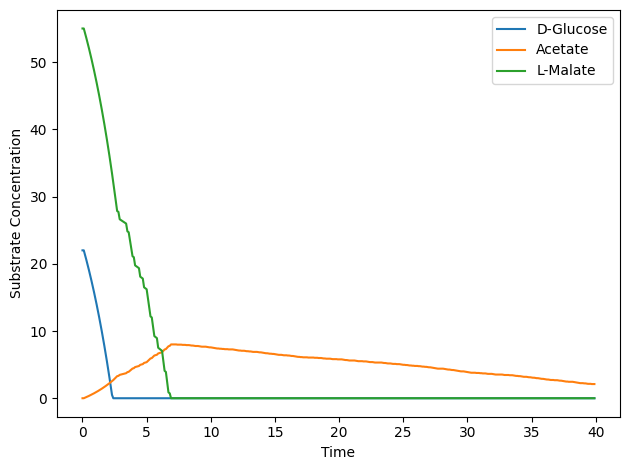

In [103]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in ['Acetate', 'L-Malate', 'D-Glucose']:
        length_diff = len(timepoints) - len(value)
        if length_diff > 0:
            # Align the data to the end of the timepoints
            aligned_timepoints = timepoints[length_diff:]
        else:
            aligned_timepoints = timepoints
        ax.plot(aligned_timepoints, value, label=key)
plt.xlabel("Time")
plt.ylabel("Substrate Concentration")
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
model = model_from_file(model_file)

In [105]:
list(model.metabolites.get_by_id('actn__R_c').reactions)[3]

Reaction identifier,ACTNabc1
Name,Acetoin efflux via ABC system
Memory address,0x3003fd5e0
Stoichiometry,actn__R_c + atp_c + h2o_c --> actn__R_e + adp_c + h_c + pi_c R Acetoin C4H8O2 + ATP C10H12N5O13P3 + H2O H2O --> R Acetoin C4H8O2 + ADP C10H12N5O10P2 + H+ + Phosphate
GPR,BSU30450 and BSU30440 and BSU30430 and BSU30420 and BSU30410
Lower bound,0.0
Upper bound,999999.0
